In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json, re

from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller, kpss
from typing import Union, Optional, Tuple
from utils.api import get_response 
from tqdm.auto import tqdm
from dotenv import load_dotenv

EPS = 1e-8            # 避免 log(0)
CLIP_RANGE = (-0.5, 0.5)  # 软限制，避免极端输出
load_dotenv()

True

In [18]:
file_path = "data/json_data/banks.json"

# 直接转成 DataFrame
df_banks = pd.read_json(file_path)

print(df_banks.head())

   permno       fdate   type             me         be    profit       Gat  \
0   10107  2010-01-01  Banks  256617.078342  41367.000  0.526047  0.225791   
1   10138  2010-01-01  Banks   14260.482627   2739.700  0.241742  0.012254   
2   10145  2010-01-01  Banks   34630.463870  12326.000  0.343907 -0.035938   
3   10147  2010-01-01  Banks   36973.757596  16492.869  0.146737  0.100050   
4   10324  2010-01-01  Banks   13831.820759   7615.331  0.115170  0.057243   

       beta   holding  mgrno  mgrid         aum    weight     outaum  \
0  0.956462  1.605804   1373      0  113.699406  0.014123  28.159731   
1  1.708220  0.324763   1373      0  113.699406  0.002856  28.159731   
2  1.306353  0.510781   1373      0  113.699406  0.004492  28.159731   
3  0.985817  0.000000   1373      0  113.699406  0.000000  28.159731   
4  0.263402  0.000000   1373      0  113.699406  0.000000  28.159731   

   outweight  
0   0.247668  
1   0.247668  
2   0.247668  
3   0.247668  
4   0.247668  


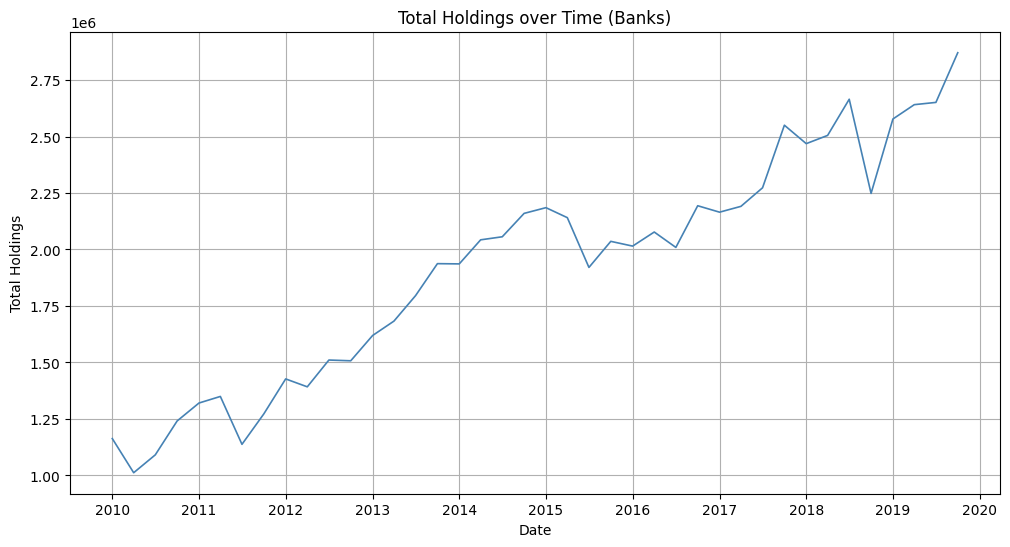

In [20]:
# 确保日期是时间类型
df_banks["fdate"] = pd.to_datetime(df_banks["fdate"])

# 按日期聚合求和
df_hold = df_banks.groupby("fdate")["holding"].sum().reset_index()

# 画图
plt.figure(figsize=(12,6))
plt.plot(df_hold["fdate"], df_hold["holding"], color="steelblue", linewidth=1.2)
plt.title("Total Holdings over Time (Banks)")
plt.xlabel("Date")
plt.ylabel("Total Holdings")
plt.grid(True)
plt.show()

In [21]:
# 确保日期是时间索引
df_hold = df_hold.set_index("fdate").sort_index()

# 取总持仓量序列
y = df_hold["holding"].dropna()

# ===== ADF 检验 =====
adf_stat, adf_p, _, _, _, _ = adfuller(y, autolag="AIC")

# ===== KPSS 检验 =====
kpss_stat, kpss_p, _, _ = kpss(y, regression="c", nlags="auto")

print(f"ADF p-value:  {adf_p:.4f}  (p<0.05 ⇒ 倾向平稳)")
print(f"KPSS p-value: {kpss_p:.4f}  (p>0.05 ⇒ 不能拒绝平稳)")

ADF p-value:  0.8767  (p<0.05 ⇒ 倾向平稳)
KPSS p-value: 0.0100  (p>0.05 ⇒ 不能拒绝平稳)


/var/folders/jb/rpmf2cds59q2g7vpj3mf6wfr0000gn/T/ipykernel_55113/82727633.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, _, _ = kpss(y, regression="c", nlags="auto")


In [22]:
# 假设 df_hold 已经是按日期聚合好的总持仓量 DataFrame
df_hold = df_hold.set_index("fdate").sort_index()

# ===== 1. 计算增量（差分） =====
df_hold["holding_diff"] = df_hold["holding"].diff()

# ===== 2. 可视化差分序列 =====
plt.figure(figsize=(12,6))
plt.plot(df_hold.index, df_hold["holding_diff"], color="darkgreen", linewidth=1)
plt.title("Differenced Total Holdings over Time (Banks)")
plt.xlabel("Date")
plt.ylabel("Δ Holdings")
plt.grid(True)
plt.show()

# ===== 3. 平稳性检验 =====
y_diff = df_hold["holding_diff"].dropna()

# ADF
adf_stat, adf_p, *_ = adfuller(y_diff, autolag="AIC")

# KPSS
kpss_stat, kpss_p, *_ = kpss(y_diff, regression="c", nlags="auto")

print(f"ADF p-value:  {adf_p:.4f}  (p<0.05 ⇒ 倾向平稳)")
print(f"KPSS p-value: {kpss_p:.4f}  (p>0.05 ⇒ 不能拒绝平稳)")

KeyError: "None of ['fdate'] are in the columns"

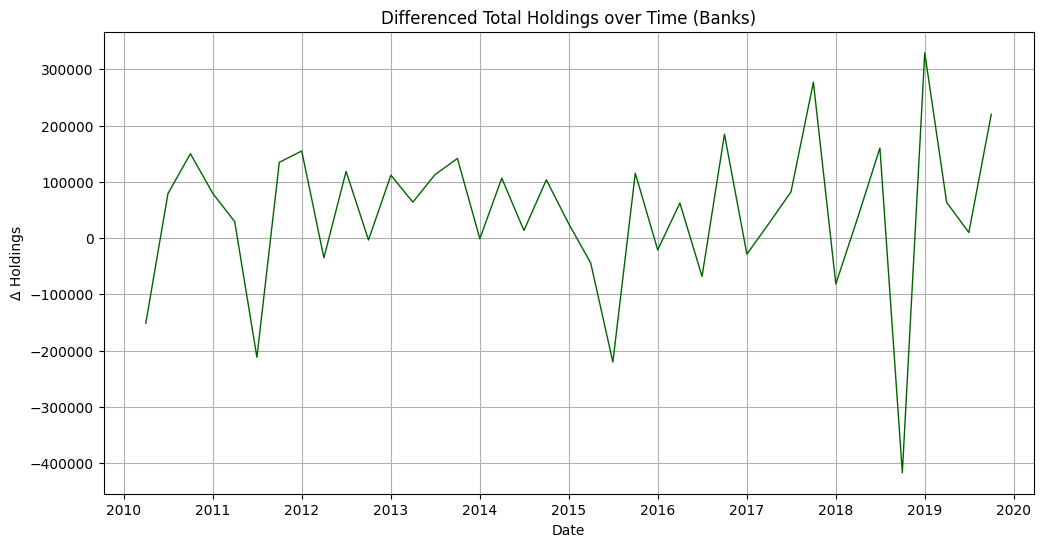

ADF p-value:  0.0000  (p<0.05 ⇒ 倾向平稳)
KPSS p-value: 0.1000  (p>0.05 ⇒ 不能拒绝平稳)


/var/folders/jb/rpmf2cds59q2g7vpj3mf6wfr0000gn/T/ipykernel_55113/997591815.py:21: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(y_diff, regression="c", nlags="auto")


In [25]:
# ===== 1. 计算增量（差分） =====
df_hold["holding_diff"] = df_hold["holding"].diff()
df_hold["holding_logret"] = np.log(df_hold["holding"]).diff()

# ===== 2. 可视化差分序列 =====
plt.figure(figsize=(12,6))
plt.plot(df_hold.index, df_hold["holding_diff"], color="darkgreen", linewidth=1)
plt.title("Differenced Total Holdings over Time (Banks)")
plt.xlabel("Date")
plt.ylabel("Δ Holdings")
plt.grid(True)
plt.show()

# ===== 3. 平稳性检验 =====
y_diff = df_hold["holding_diff"].dropna()

# ADF
adf_stat, adf_p, *_ = adfuller(y_diff, autolag="AIC")

# KPSS
kpss_stat, kpss_p, *_ = kpss(y_diff, regression="c", nlags="auto")

print(f"ADF p-value:  {adf_p:.4f}  (p<0.05 ⇒ 倾向平稳)")
print(f"KPSS p-value: {kpss_p:.4f}  (p>0.05 ⇒ 不能拒绝平稳)")

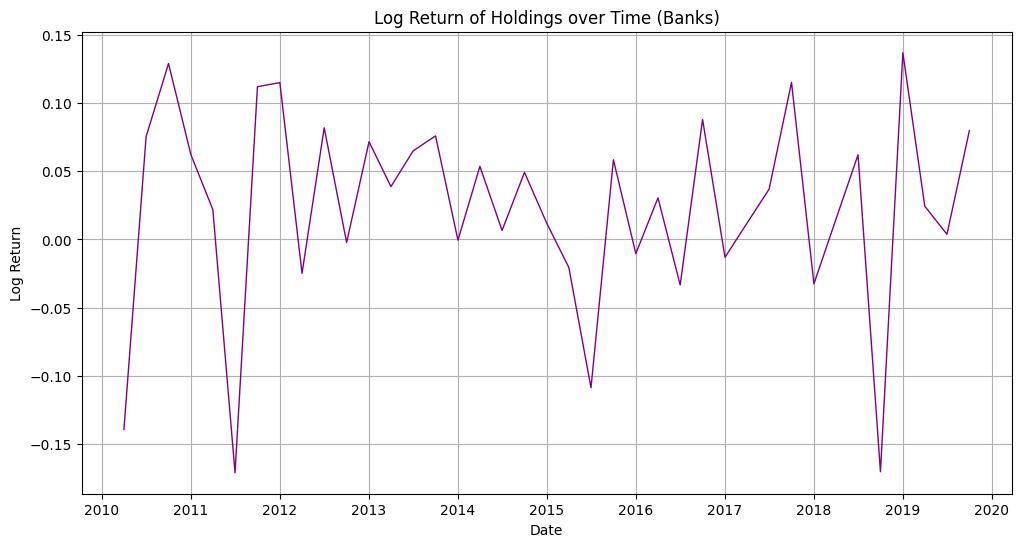

ADF p-value:  0.0000  (p<0.05 ⇒ 倾向平稳)
KPSS p-value: 0.1000  (p>0.05 ⇒ 不能拒绝平稳)


/var/folders/jb/rpmf2cds59q2g7vpj3mf6wfr0000gn/T/ipykernel_55113/1552582167.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(y_ret, regression="c", nlags="auto")


In [26]:
# 可视化对数增长率
plt.figure(figsize=(12,6))
plt.plot(df_hold.index, df_hold["holding_logret"], color="purple", linewidth=1)
plt.title("Log Return of Holdings over Time (Banks)")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.grid(True)
plt.show()

# 平稳性检验
y_ret = df_hold["holding_logret"].dropna()

# ADF
adf_stat, adf_p, *_ = adfuller(y_ret, autolag="AIC")

# KPSS
kpss_stat, kpss_p, *_ = kpss(y_ret, regression="c", nlags="auto")

print(f"ADF p-value:  {adf_p:.4f}  (p<0.05 ⇒ 倾向平稳)")
print(f"KPSS p-value: {kpss_p:.4f}  (p>0.05 ⇒ 不能拒绝平稳)")

In [3]:
# 读取
df_banks = pd.read_json("data/json_data/banks.json")
# 只留 Banks（如需）
df_banks = df_banks[df_banks["type"] == "Banks"].copy()

# 时间 & 排序
df_banks["fdate"] = pd.to_datetime(df_banks["fdate"])
df_banks = df_banks.sort_values(["mgrno", "permno", "fdate"])

# 关键列检查
need_cols = ["mgrno","permno","fdate","holding","me","be","profit","Gat","beta"]
missing = [c for c in need_cols if c not in df_banks.columns]
assert not missing, f"缺少列: {missing}"

mgrno_sel, permno_sel = 7800, 10107

df_sub = (
    df_banks[(df_banks["mgrno"] == mgrno_sel) & (df_banks["permno"] == permno_sel)]
    .sort_values("fdate")
    .reset_index(drop=True)
)

print(df_sub.head())

   permno      fdate   type             me       be    profit       Gat  \
0   10107 2010-01-01  Banks  256617.078342  41367.0  0.526047  0.225791   
1   10107 2010-04-01  Banks  199118.578651  44815.0  0.543099  0.221482   
2   10107 2010-07-01  Banks  209683.378040  47070.0  0.526365  0.209618   
3   10107 2010-10-01  Banks  234527.728718  47764.0  0.558559  0.100388   
4   10107 2011-01-01  Banks  214063.084854  48916.0  0.600090  0.114800   

       beta      holding  mgrno  mgrid            aum    weight        outaum  \
0  0.956462   938.151270   7800      0   76729.489694  0.012227  23390.515178   
1  0.997816  2543.581754   7800      0  132534.043575  0.019192  38036.223751   
2  1.065889  1377.187741   7800      0   65663.482842  0.020973  18317.464362   
3  1.035369  1412.812370   7800      0   76448.489544  0.018481  22028.543855   
4  1.021567  1292.896955   7800      0   78066.819822  0.016561  21979.070419   

   outweight  
0   0.304844  
1   0.286992  
2   0.278960  
3 

In [4]:
EPS = 1e-8

# 增长率 r_{t+1} = log((H_{t+1}+eps)/(H_t+eps))
df_sub["holding_tp1"] = df_sub["holding"].shift(-1)
df_sub["target_change_rate"] = np.log1p(df_sub["holding_tp1"] + EPS) - np.log1p(df_sub["holding"] + EPS)

# 去掉缺失（最后一行没有 t+1）
df_sub = df_sub.dropna(subset=["target_change_rate"])
print(df_sub[["fdate","holding","holding_tp1","target_change_rate"]].head())

       fdate      holding  holding_tp1  target_change_rate
0 2010-01-01   938.151270  2543.581754            0.996745
1 2010-04-01  2543.581754  1377.187741           -0.613197
2 2010-07-01  1377.187741  1412.812370            0.025520
3 2010-10-01  1412.812370  1292.896955           -0.088631
4 2011-01-01  1292.896955  1565.984316            0.191494


In [5]:
from statsmodels.tsa.stattools import adfuller, kpss

y = df_sub["target_change_rate"].dropna()

adf_p = adfuller(y, autolag="AIC")[1]
kpss_p = kpss(y, regression="c", nlags="auto")[1]

print(f"ADF p={adf_p:.4f}  (p<0.05 ⇒ 平稳)")
print(f"KPSS p={kpss_p:.4f} (p>0.05 ⇒ 不能拒绝平稳)")

ADF p=0.0000  (p<0.05 ⇒ 平稳)
KPSS p=0.1000 (p>0.05 ⇒ 不能拒绝平稳)


/var/folders/jb/rpmf2cds59q2g7vpj3mf6wfr0000gn/T/ipykernel_66238/3068580941.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p = kpss(y, regression="c", nlags="auto")[1]


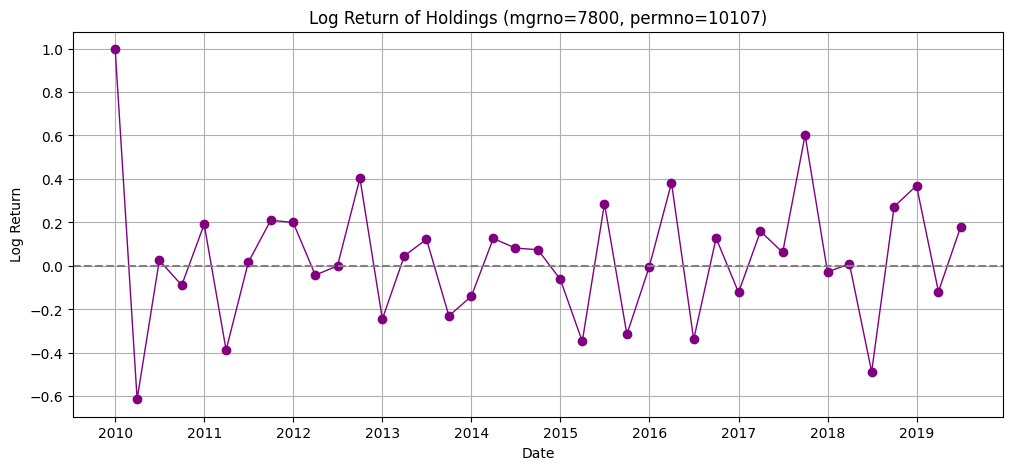

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df_sub["fdate"], df_sub["target_change_rate"], marker="o", color="purple", linewidth=1)
plt.axhline(0, color="gray", linestyle="--")
plt.title(f"Log Return of Holdings (mgrno={mgrno_sel}, permno={permno_sel})")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.grid(True)
plt.show()

In [36]:
def _fmt_date(d):
    try:
        return pd.to_datetime(d).date().isoformat()
    except Exception:
        return str(d)

def build_single_prompt_return(row_t, prev_row, investor_role, investor_id, hist_guard=None):
    # 必要字段检查
    need_t   = ["permno","fdate","me","be","profit","Gat","beta","holding"]
    need_tm1 = ["fdate","me","be","profit","Gat","beta"]
    for cols, nm in [(need_t,"row_t"), (need_tm1,"prev_row")]:
        miss = [c for c in cols if c not in (row_t if nm=="row_t" else prev_row).index]
        if miss:
            raise KeyError(f"{nm} 缺少列: {miss}")

    stock_id = row_t["permno"]
    fdate_t  = _fmt_date(row_t["fdate"])
    fdate_tm1= _fmt_date(prev_row["fdate"])
    fdate_tp1= _fmt_date(pd.to_datetime(row_t["fdate"]) + pd.DateOffset(months=3))

    # fundamentals
    me_t, be_t, profit_t, Gat_t, beta_t = row_t[["me","be","profit","Gat","beta"]]
    me_tm1, be_tm1, profit_tm1, Gat_tm1, beta_tm1 = prev_row[["me","be","profit","Gat","beta"]]

    holding_t = row_t["holding"]

    guard_text = ""
    if isinstance(hist_guard, tuple) and len(hist_guard)==2:
        lo, hi = hist_guard
        guard_text = f"- Typical change_rate range (soft): [{lo:.3f}, {hi:.3f}]\n"

    prompt = f"""
Act as a quantitative portfolio manager at a {investor_role} institution.

Task: Predict the **next quarter (t+1)** holding **change_rate** defined as
  change_rate = log((H_(t+1)+eps)/(H_t+eps)),
where eps is a small constant for numerical stability.
Do **NOT** output H_(t) or H_(t+1). Output only the **change_rate**.

Investor:
- investor_type: {investor_role}
- investor_id (mgrno): {investor_id}

Stock:
- stock_id (permno): {stock_id}

Timeline:
- previous_quarter (t-1): {fdate_tm1}
- current_quarter  (t):   {fdate_t}
- target_quarter   (t+1): {fdate_tp1}

Context:
- Current holding H_t (scale only, NOT target): {holding_t}
{guard_text}
Previous-quarter fundamentals (t-1):
me={me_tm1}, be={be_tm1}, profit={profit_tm1}, Gat={Gat_tm1}, beta={beta_tm1}

Current-quarter fundamentals (t):
me={me_t}, be={be_t}, profit={profit_t}, Gat={Gat_t}, beta={beta_t}

Guidance:
- Focus on fundamentals at (t) and their change from (t-1)→(t).
- Do NOT copy H_t; predict relative change only.
- Reasonable change_rate is roughly [-0.5, 0.5]; values beyond this are unusual.
- Output must be one numeric float in valid JSON.

OUTPUT (valid JSON ONLY):
{{"change_rate": <float>}}
""".strip()
    return prompt

def parse_change_rate(text):
    try:
        obj = json.loads(text)
        if isinstance(obj, dict) and "change_rate" in obj:
            return float(obj["change_rate"])
    except Exception:
        pass
    m = re.search(r'([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)', str(text))
    if m:
        return float(m.group(1))
    return np.nan

def call_model_for_change_rate(prompt, clip_range=CLIP_RANGE):
    raw = get_response(prompt)
    r = parse_change_rate(raw)
    if np.isfinite(r):
        r = float(np.clip(r, *clip_range))
    return r, raw

def invert_to_level(H_t, change_rate):
    return np.expm1(np.log1p(H_t) + change_rate)

In [27]:
# 读取并准备
df_banks = pd.read_json("data/json_data/banks.json")
df_banks["fdate"] = pd.to_datetime(df_banks["fdate"])
df_banks = df_banks.sort_values(["mgrno","permno","fdate"])

# 只看一个组合
mgrno_sel, permno_sel = 7800, 10107
df_sub = df_banks[(df_banks["mgrno"]==mgrno_sel) & (df_banks["permno"]==permno_sel)].copy()
df_sub = df_sub.sort_values("fdate").reset_index(drop=True)

# 构造目标: r_{t+1} = log((H_{t+1}+eps)/(H_t+eps))
df_sub["holding_tp1"] = df_sub["holding"].shift(-1)
df_sub["target_change_rate"] = (
    np.log1p(df_sub["holding_tp1"] + EPS) - np.log1p(df_sub["holding"] + EPS)
)

# 去掉最后一行
df_sub = df_sub.dropna(subset=["target_change_rate"]).reset_index(drop=True)

print(df_sub[["fdate","holding","holding_tp1","target_change_rate"]].head())

       fdate      holding  holding_tp1  target_change_rate
0 2010-01-01   938.151270  2543.581754            0.996745
1 2010-04-01  2543.581754  1377.187741           -0.613197
2 2010-07-01  1377.187741  1412.812370            0.025520
3 2010-10-01  1412.812370  1292.896955           -0.088631
4 2011-01-01  1292.896955  1565.984316            0.191494


In [ ]:
# 选择一个样本：用第 2 行作为 t，第 1 行作为 t-1
i = 1
assert len(df_sub) > i, "子集样本太少，无法取到第 2 条（索引 1）"
row_t = df_sub.iloc[i]
prev_row = df_sub.iloc[i-1]

# 生成 prompt（带五个因子 & change_rate 目标）
prompt = build_single_prompt_return(
    row_t=row_t,
    prev_row=prev_row,
    investor_role="Banks",
    investor_id=int(row_t["mgrno"]),
    hist_guard=(-0.5, 0.5)   # 可换成历史分位数 (q5, q95)
)

print(prompt)

Act as a quantitative portfolio manager at a Banks institution.

Task: Predict the **next quarter (t+1)** holding **change_rate** defined as
  change_rate = log((H_(t+1)+eps)/(H_t+eps)),
where eps is a small constant for numerical stability.
Do **NOT** output H_(t) or H_(t+1). Output only the **change_rate**.

Investor:
- investor_type: Banks
- investor_id (mgrno): 7800

Stock:
- stock_id (permno): 10107

Timeline:
- previous_quarter (t-1): 2010-01-01
- current_quarter  (t):   2010-04-01
- target_quarter   (t+1): 2010-07-01

Context:
- Current holding H_t (scale only, NOT target): 2543.5817537812
- Typical change_rate range (soft): [-0.500, 0.500]

Previous-quarter fundamentals (t-1):
me=256617.0783424377, be=41367.0, profit=0.5260473324, Gat=0.2257906581, beta=0.956462102

Current-quarter fundamentals (t):
me=199118.5786506443, be=44815.0, profit=0.5430994087000001, Gat=0.2214822445, beta=0.9978163022000001

Guidance:
- Focus on fundamentals at (t) and their change from (t-1)→(t).
- D

In [41]:
records = []

total_steps = max(len(df_sub) - 1, 0)

for i in tqdm(range(1, len(df_sub)), total=total_steps, desc="Predicting change_rate"):
    row_t = df_sub.loc[i]
    prev_row = df_sub.loc[i-1]

    prompt = build_single_prompt_return(row_t, prev_row, "Banks", mgrno_sel)

    try:
        r_pred, raw_text = call_model_for_change_rate(prompt)
    except Exception as e:
        r_pred, raw_text = np.nan, f"[CALL_ERROR] {e}"

    H_t = row_t["holding"]
    H_tp1_true = row_t["holding_tp1"]
    H_tp1_pred = invert_to_level(H_t, r_pred) if np.isfinite(r_pred) else np.nan

    records.append({
        "fdate_t": row_t["fdate"],
        "fdate_tp1": pd.to_datetime(row_t["fdate"]) + pd.DateOffset(months=3),
        "H_t": H_t,
        "H_tp1_true": H_tp1_true,
        "r_true": row_t["target_change_rate"],
        "r_pred": r_pred,
        "H_tp1_pred": H_tp1_pred,
        "raw_model_text": raw_text
    })

df_eval = pd.DataFrame(records)
print(df_eval.head())

Predicting change_rate: 100%|██████████| 38/38 [02:09<00:00,  3.42s/it]

     fdate_t  fdate_tp1          H_t   H_tp1_true    r_true  r_pred  \
0 2010-04-01 2010-07-01  2543.581754  1377.187741 -0.613197  -0.218   
1 2010-07-01 2010-10-01  1377.187741  1412.812370  0.025520  -0.042   
2 2010-10-01 2011-01-01  1412.812370  1292.896955 -0.088631   0.127   
3 2011-01-01 2011-04-01  1292.896955  1565.984316  0.191494   0.127   
4 2011-04-01 2011-07-01  1565.984316  1063.475203 -0.386671   0.012   

    H_tp1_pred           raw_model_text  
0  2045.162927  {"change_rate": -0.218}  
1  1320.502577  {"change_rate": -0.042}  
2  1604.266625   {"change_rate": 0.127}  
3  1468.112623   {"change_rate": 0.127}  
4  1584.901403   {"change_rate": 0.012}  


In [45]:
mask = np.isfinite(df_eval["r_pred"])
y_true = df_eval.loc[mask, "H_tp1_true"]
y_pred = df_eval.loc[mask, "H_tp1_pred"]
baseline = df_eval.loc[mask, "H_t"]

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))   # 手动 sqrt
baseline_mae = mean_absolute_error(y_true, baseline)

print(f"MAE={mae:.2f}, RMSE={rmse:.2f}, Baseline MAE={baseline_mae:.2f}")

MAE=399.03, RMSE=524.39, Baseline MAE=374.57


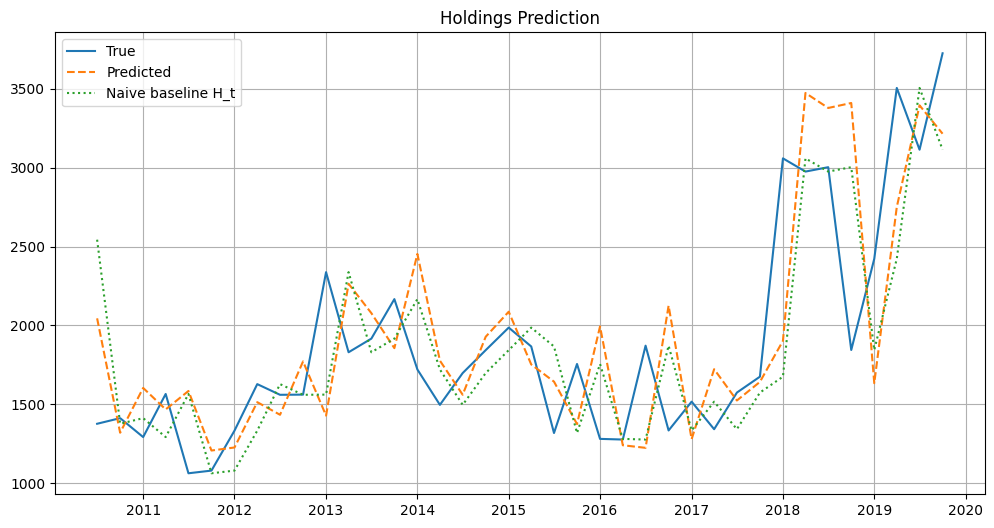

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df_eval["fdate_tp1"], df_eval["H_tp1_true"], label="True")
plt.plot(df_eval["fdate_tp1"], df_eval["H_tp1_pred"], "--", label="Predicted")
plt.plot(df_eval["fdate_tp1"], df_eval["H_t"], ":", label="Naive baseline H_t")
plt.legend(); plt.grid(); plt.title("Holdings Prediction"); plt.show()

In [47]:
EPS = 1e-8

# 已有：df_sub 按时间升序，并含 holding_tp1 / target_change_rate
# 新增：t-2 fundamentals & r_t（滞后收益率）
for col in ["me","be","profit","Gat","beta"]:
    df_sub[f"{col}_tm1"] = df_sub[col].shift(1)
    df_sub[f"{col}_tm2"] = df_sub[col].shift(2)

df_sub["holding_tm1"] = df_sub["holding"].shift(1)
df_sub["lag_return_rt"] = np.log1p(df_sub["holding"] + EPS) - np.log1p(df_sub["holding_tm1"] + EPS)

# 需要至少到 t-2 才能构造样本
df_sub2 = df_sub.dropna(subset=[
    "holding_tp1","target_change_rate",
    "me_tm1","be_tm1","profit_tm1","Gat_tm1","beta_tm1",
    "me_tm2","be_tm2","profit_tm2","Gat_tm2","beta_tm2",
    "holding_tm1","lag_return_rt"
]).reset_index(drop=True)

In [48]:
def build_single_prompt_return_win2(row_t, row_tm1, row_tm2, investor_role, investor_id, hist_guard=None):
    def _fmt_date(d):
        try: return pd.to_datetime(d).date().isoformat()
        except: return str(d)

    need_cols = ["permno","fdate","me","be","profit","Gat","beta","holding"]
    for nm, r in [("row_t",row_t), ("row_tm1",row_tm1), ("row_tm2",row_tm2)]:
        missing = [c for c in need_cols if c not in r.index]
        if missing: raise KeyError(f"{nm} 缺少列: {missing}")

    stock_id = row_t["permno"]
    f_t, f_tm1, f_tm2 = map(_fmt_date, [row_t["fdate"], row_tm1["fdate"], row_tm2["fdate"]])
    f_tp1 = _fmt_date(pd.to_datetime(row_t["fdate"]) + pd.DateOffset(months=3))

    guard_text = ""
    if isinstance(hist_guard, tuple) and len(hist_guard)==2:
        guard_text = f"- Typical change_rate range (soft): [{hist_guard[0]:.3f}, {hist_guard[1]:.3f}]\n"

    prompt = f"""
Act as a quantitative portfolio manager at a {investor_role} institution.

Task: Predict the **next quarter (t+1)** holding **change_rate**:
  change_rate = log((H_(t+1)+eps)/(H_t+eps)).

Investor:
- investor_type: {investor_role}
- investor_id (mgrno): {investor_id}
- stock_id (permno): {stock_id}

Timeline:
- (t-2): {f_tm2}
- (t-1): {f_tm1}
- (t):   {f_t}
- (t+1): {f_tp1}

Context:
- Current holding H_t (scale only): {row_t['holding']}
- Last-period log return r_t = log((H_t+eps)/(H_(t-1)+eps)): {row_t.get('lag_return_rt', 'N/A')}
{guard_text}
Fundamentals (t-2):
me={row_tm2['me']}, be={row_tm2['be']}, profit={row_tm2['profit']}, Gat={row_tm2['Gat']}, beta={row_tm2['beta']}

Fundamentals (t-1):
me={row_tm1['me']}, be={row_tm1['be']}, profit={row_tm1['profit']}, Gat={row_tm1['Gat']}, beta={row_tm1['beta']}

Fundamentals (t):
me={row_t['me']}, be={row_t['be']}, profit={row_t['profit']}, Gat={row_t['Gat']}, beta={row_t['beta']}

Guidance:
- Use levels at (t) and changes from (t-2)->(t-1)->(t) jointly.
- r_t gives momentum; do NOT copy H_t; predict relative change only.
- Reasonable change_rate ~ [-0.5, 0.5]. Output JSON only.

OUTPUT:
{{"change_rate": <float>}}
""".strip()
    return prompt

In [49]:
records = []
from tqdm.auto import tqdm

y_hist = df_sub2["target_change_rate"].dropna()
qlo, qhi = (y_hist.quantile(0.05), y_hist.quantile(0.95)) if len(y_hist)>5 else (-0.5,0.5)

for i in tqdm(range(2, len(df_sub2)), desc="Predicting change_rate (win=2)"):
    row_t   = df_sub2.loc[i]
    row_tm1 = df_sub2.loc[i-1]
    row_tm2 = df_sub2.loc[i-2]

    prompt = build_single_prompt_return_win2(row_t, row_tm1, row_tm2, "Banks", mgrno_sel, (qlo,qhi))
    r_pred, raw_text = call_model_for_change_rate(prompt)  # 复用你的解析+裁剪

    H_t = row_t["holding"]
    H_tp1_true = row_t["holding_tp1"]
    H_tp1_pred = invert_to_level(H_t, r_pred) if np.isfinite(r_pred) else np.nan

    records.append({
        "fdate_t": row_t["fdate"],
        "fdate_tp1": pd.to_datetime(row_t["fdate"]) + pd.DateOffset(months=3),
        "H_t": H_t, "H_tp1_true": H_tp1_true,
        "r_true": row_t["target_change_rate"], "r_pred": r_pred,
        "H_tp1_pred": H_tp1_pred, "raw_model_text": raw_text
    })

df_eval_win2 = pd.DataFrame(records).reset_index(drop=True)

Predicting change_rate (win=2): 100%|██████████| 35/35 [02:13<00:00,  3.81s/it]


[win=2] MAE=403.61, RMSE=533.56 | Baseline MAE=368.91


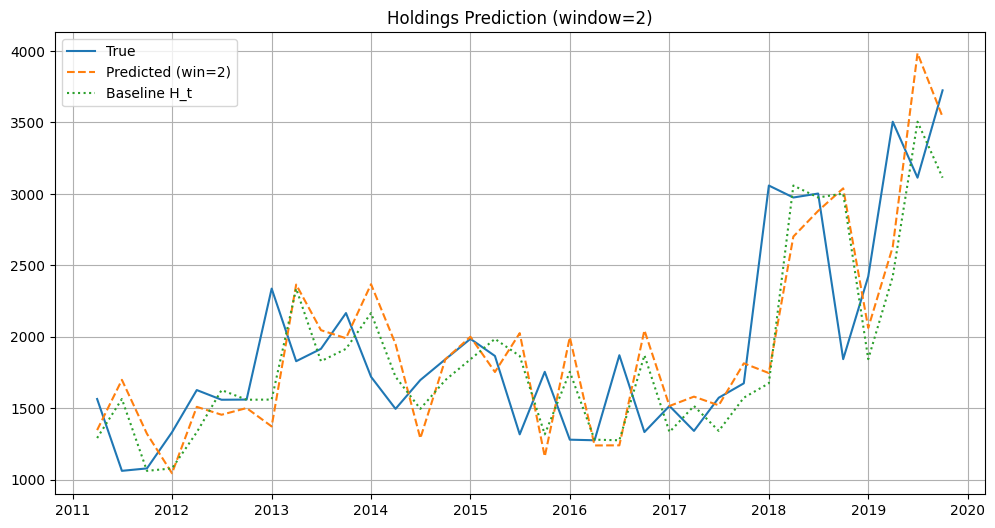

In [50]:
mask = np.isfinite(df_eval_win2["r_pred"])
y_true = df_eval_win2.loc[mask,"H_tp1_true"].to_numpy()
y_pred = df_eval_win2.loc[mask,"H_tp1_pred"].to_numpy()
baseline = df_eval_win2.loc[mask,"H_t"].to_numpy()

mae  = np.mean(np.abs(y_pred - y_true))
rmse = np.sqrt(np.mean((y_pred - y_true)**2))
mae_base = np.mean(np.abs(baseline - y_true))
print(f"[win=2] MAE={mae:.2f}, RMSE={rmse:.2f} | Baseline MAE={mae_base:.2f}")

plt.figure(figsize=(12,6))
plt.plot(df_eval_win2.loc[mask,"fdate_tp1"], y_true, label="True")
plt.plot(df_eval_win2.loc[mask,"fdate_tp1"], y_pred, "--", label="Predicted (win=2)")
plt.plot(df_eval_win2.loc[mask,"fdate_tp1"], baseline, ":", label="Baseline H_t")
plt.title("Holdings Prediction (window=2)"); plt.legend(); plt.grid(); plt.show()